<a href="https://colab.research.google.com/github/nnajeh/Pretrained-models/blob/main/Finetuning_pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libraries

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [3]:
#Choose the pretrained model
model_name = "resnet"

In [52]:
# Data directory
data_dir = '/content/drive/MyDrive/ChestX-ray-dataset/NIH'

# Number of classes in the dataset
num_classes = 13

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#number of epochs
epochs =20

In [41]:
# Data transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}


In [42]:
image_datasets = {x: datasets.ImageFolder(data_dir, data_transforms[x])
                  for x in ['train', 'val']}

In [44]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [45]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [46]:
#class_names = image_datasets['train'].classes

In [74]:
#Classes name
class_names = ['Cardiomegaly', 'Atelectasis', 'Consolidation','Edema','Enlarged Cardiomediastinum','Fracture','Lung Lesion','Lung Opacity','Pleural Effusion','Pneumonia', 'Pneumothorax', 'Pleural Other', 'No Finding']

In [75]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


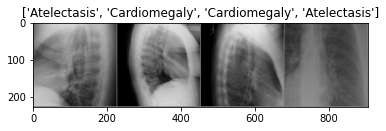

In [77]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [78]:
#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [79]:
#Visualizing the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [80]:
from torch.optim import lr_scheduler 

In [ ]:
#@title Finetuning the convnet

In [81]:
#Finetuning the convnet
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [82]:
#Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2448 Acc: 0.9466
val Loss: 0.2288 Acc: 0.9481

Epoch 1/19
----------
train Loss: 0.2470 Acc: 0.9454
val Loss: 0.2279 Acc: 0.9482

Epoch 2/19
----------
train Loss: 0.2368 Acc: 0.9475
val Loss: 0.7654 Acc: 0.5953

Epoch 3/19
----------
train Loss: 0.2354 Acc: 0.9470
val Loss: 0.2543 Acc: 0.9482

Epoch 4/19
----------
train Loss: 0.2316 Acc: 0.9473
val Loss: 0.2239 Acc: 0.9482

Epoch 5/19
----------
train Loss: 0.2240 Acc: 0.9481
val Loss: 0.2105 Acc: 0.9482

Epoch 6/19
----------
train Loss: 0.2190 Acc: 0.9475
val Loss: 0.2103 Acc: 0.9482

Epoch 7/19
----------
train Loss: 0.2064 Acc: 0.9482
val Loss: 0.2044 Acc: 0.9482

Epoch 8/19
----------
train Loss: 0.2051 Acc: 0.9482
val Loss: 0.2037 Acc: 0.9482

Epoch 9/19
----------
train Loss: 0.2058 Acc: 0.9482
val Loss: 0.2051 Acc: 0.9482

Epoch 10/19
----------
train Loss: 0.2054 Acc: 0.9482
val Loss: 0.2032 Acc: 0.9482

Epoch 11/19
----------
train Loss: 0.2043 Acc: 0.9482
val Loss: 0.2060 Acc: 0.9482

Epoch 12/19
----------
t

In [61]:
#ConvNet as fixed feature extractor
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [62]:
#
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2419 Acc: 0.9471
val Loss: 0.2180 Acc: 0.9482

Epoch 1/19
----------
train Loss: 0.2446 Acc: 0.9467
val Loss: 0.2897 Acc: 0.9482

Epoch 2/19
----------
train Loss: 0.2429 Acc: 0.9462
val Loss: 0.2158 Acc: 0.9481

Epoch 3/19
----------
train Loss: 0.2399 Acc: 0.9466
val Loss: 0.2426 Acc: 0.9482

Epoch 4/19
----------
train Loss: 0.2432 Acc: 0.9465
val Loss: 0.2941 Acc: 0.9482

Epoch 5/19
----------
train Loss: 0.2424 Acc: 0.9466
val Loss: 0.2582 Acc: 0.9482

Epoch 6/19
----------
train Loss: 0.2421 Acc: 0.9458
val Loss: 0.2420 Acc: 0.9412

Epoch 7/19
----------
train Loss: 0.2124 Acc: 0.9482
val Loss: 0.2123 Acc: 0.9479

Epoch 8/19
----------
train Loss: 0.2124 Acc: 0.9482
val Loss: 0.2102 Acc: 0.9481

Epoch 9/19
----------
train Loss: 0.2105 Acc: 0.9482
val Loss: 0.2125 Acc: 0.9482

Epoch 10/19
----------
train Loss: 0.2075 Acc: 0.9482
val Loss: 0.2090 Acc: 0.9482

Epoch 11/19
----------
train Loss: 0.2084 Acc: 0.9482
val Loss: 0.2077 Acc: 0.9482

Epoch 12/19
----------
t